In [1]:
from pandas import DataFrame
from MyModule import Vocab, load_vocab, load_data

train_seg = load_data('train_segmented.txt', sep='<sp>', is_segmented=True)
val_seg = load_data('val_segmented.txt', sep='<sp>', is_segmented=True)
test_seg = load_data('test_segmented.txt', sep='<sp>', is_segmented=True)

train_idx = load_data('train_indexed.txt', sep=',', is_indexed=True)
val_idx = load_data('val_indexed.txt', sep=',', is_indexed=True)
test_idx = load_data('test_indexed.txt', sep=',', is_indexed=True)

vocab = load_vocab('vocab.txt')

e:\anaconda3\envs\nlpllma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 通用训练、验证和测试框架
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import json
import os
from datetime import datetime
import copy

def train_model_with_validation(  #@save
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        criterion=nn.CrossEntropyLoss(), 
        num_epochs=10, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive'],
        patience=3,
        min_delta=0.001
        ):
    """
    通用的模型训练函数，支持验证集评估和早停机制
    
    Args:
        model: PyTorch模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器 (可选)
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        device: 设备 (cpu/cuda)
        target_names: 类别名称列表
        patience: 早停耐心值，验证损失不下降的最大轮数
        min_delta: 最小改善阈值，小于此值视为没有改善
        
    Returns:
        dict: 包含训练历史的字典
    """
    
    # 训练历史记录
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
        'val_f1_scores': [],
        'val_precision_scores': [],
        'val_recall_scores': []
    }
    
    # 早停相关变量
    if patience is not None and val_loader is not None:
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            # 处理不同模型的输入格式
            if len(batch) == 2:  # CNN
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM and Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            loss = criterion(logits, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)
        
        # 记录训练指标
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_acc)
        
        # 验证阶段
        if val_loader is not None:
            val_metrics = evaluate_model(model, val_loader, criterion, device)
            history['val_losses'].append(val_metrics['loss'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['val_f1_scores'].append(val_metrics['f1'])
            history['val_precision_scores'].append(val_metrics['precision'])
            history['val_recall_scores'].append(val_metrics['recall'])
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train Loss: {avg_train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")
            print(f"    Valid Loss: {val_metrics['loss']:.4f}\tValid Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"    Valid Precision: {val_metrics['precision']:.4f}\tValid Recall: {val_metrics['recall']:.4f}\tValid F1: {val_metrics['f1']:.4f}")
            
            # 早停检查
            if patience is not None:
                current_val_loss = val_metrics['loss']
                if current_val_loss < best_val_loss - min_delta:
                    best_val_loss = current_val_loss
                    patience_counter = 0
                    best_model_state = copy.deepcopy(model.state_dict())
                    print(f"    ✓ New best validation loss: {best_val_loss:.4f}")
                else:
                    patience_counter += 1
                    print(f"    No improvement. Patience: {patience_counter}/{patience}")
                    
                if patience_counter >= patience:
                    print(f"    Early stopping triggered! Best validation loss: {best_val_loss:.4f}")
                    model.load_state_dict(best_model_state)
                    break
            
            print('-' * 80)
            
            # 最后一个epoch打印详细报告
            if epoch == num_epochs - 1:
                print("\nDetailed Classification Report:")
                print(classification_report(val_metrics['true_labels'], val_metrics['pred_labels'], 
                                          target_names=target_names, digits=4))
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_acc:.4f}")
    
    # 添加早停信息到历史记录
    if patience is not None and val_loader is not None:
        history['early_stopped'] = patience_counter >= patience
        history['best_val_loss'] = best_val_loss
        history['stopped_epoch'] = epoch + 1 if patience_counter >= patience else num_epochs
    
    return history

def evaluate_model(  #@save
        model, 
        data_loader, 
        criterion=nn.CrossEntropyLoss(), 
        device=torch.device('cuda')
        ):
    """
    通用的模型评估函数
    
    Args:
        model: PyTorch模型
        data_loader: 数据加载器
        criterion: 损失函数
        device: 设备
        
    Returns:
        dict: 评估结果字典
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            # 处理不同模型的输入格式
            if len(batch) == 2:  # CNN, basic models
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM, Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            loss = criterion(logits, targets)
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': all_targets,
        'pred_labels': all_preds
    }

def test_model_comprehensive(  #@save
        model, 
        model_name, 
        test_loader, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive']
        ):
    """
    全面的模型测试函数，包含F1分数和混淆矩阵
    
    Args:
        model: PyTorch模型
        model_name: 模型名称
        test_loader: 测试数据加载器
        device: 设备
        target_names: 类别名称列表
        
    Returns:
        dict: 测试结果字典
    """
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 处理不同模型的输入格式
            if len(batch) == 2:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
            elif len(batch) == 3:
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    outputs = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs, lengths)
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    test_accuracy = correct / total
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # 计算每个类别的指标
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    
    # 输出结果
    print("\n" + "="*80)
    print("TEST RESULTS")
    print("="*80)
    print(f"Model Name: {model_name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision (weighted): {test_precision:.4f}")
    print(f"Test Recall (weighted): {test_recall:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}")
    
    # 详细分类报告
    print("\nDetailed Test Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(model_name, all_targets, all_preds, target_names)

    # 打印每个类别的指标
    print("\nPer-Class Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(target_names):
        print(f"{class_name:>8}: Precision={class_precision[i]:.4f}, "
              f"Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}, "
              f"Support={int(class_support[i])}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

def plot_confusion_matrix(model_name, true_labels, pred_labels, target_names):  #@save
    """绘制规范化混淆矩阵"""
    plt.figure(figsize=(8, 6))
    
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Proportion'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_training_curves(model_name, history, save_path=None):  #@save
    """绘制训练曲线"""
    num_epochs = len(history['train_losses'])
    
    plt.figure(figsize=(15, 5))
    
    # 训练损失和准确率
    plt.subplot(1, 2, 1)
    epochs_range = range(1, num_epochs+1)
    plt.plot(epochs_range, history['train_losses'], 'b--', label='Train Loss', linewidth=2)
    plt.plot(epochs_range, history['train_accuracies'], 'r-', label='Train Acc', linewidth=2)
    if history['val_accuracies']:
        plt.plot(epochs_range, history['val_accuracies'], 'g-', label='Val Acc', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Training Loss & Accuracy - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(1, 10)
    plt.ylim(0, 1.0)
    
    # 设置x轴刻度为整数
    plt.xticks(epochs_range)
    
    # 过拟合监控
    if history['val_accuracies']:
        plt.subplot(1, 2, 2)
        acc_diff = [train_acc - val_acc for train_acc, val_acc in 
                   zip(history['train_accuracies'], history['val_accuracies'])]
        plt.plot(epochs_range, acc_diff, 'purple', label='Train - Val Accuracy', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Difference')
        plt.title(f'Overfitting Monitor - {model_name}')
        plt.xlim(1, 10)
        plt.ylim(-0.2, 0.5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        
        # 设置x轴刻度为整数
        plt.xticks(epochs_range)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def print_training_summary(model_name, history):  #@save
    """打印训练摘要"""
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Model Name: {model_name}")
    print(f"Final Train Loss: {history['train_losses'][-1]:.4f}")
    print(f"Final Train Accuracy: {history['train_accuracies'][-1]:.4f}")
    
    if history['val_accuracies']:
        print(f"Final Val Loss: {history['val_losses'][-1]:.4f}")
        print(f"Final Val Accuracy: {history['val_accuracies'][-1]:.4f}")
        print(f"Best Val Accuracy: {max(history['val_accuracies']):.4f} (Epoch {history['val_accuracies'].index(max(history['val_accuracies']))+1})")
        print(f"Final Overfitting Gap: {history['train_accuracies'][-1] - history['val_accuracies'][-1]:.4f}")


def convert_numpy_to_python(obj):  #@save
    """
    递归地将NumPy数组和其他不可JSON序列化的对象转换为Python原生类型
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_numpy_to_python(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_python(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_to_python(item) for item in obj)
    else:
        return obj

def save_training_results(  #@save
    model, 
    model_name, 
    actual_epochs, 
    device, 
    use_pretrained_embeddings, 
    training_history, 
    test_results, 
    save_path="model_training_results.json"
):
    """
    保存模型训练结果到JSON文件
    
    Args:
        model: PyTorch模型实例
        model_name: 模型名称字符串
        actual_epochs: 实际训练的迭代次数
        device: 训练设备 (torch.device 或字符串)
        use_pretrained_embeddings: 是否使用预训练词向量 (布尔值)
        training_history: 训练历史字典 (包含losses, accuracies等)
        test_results: 测试结果字典 (包含accuracy, f1等指标)
        save_path: JSON文件保存路径
    
    Returns:
        dict: 保存的记录字典
    """
    
    # 深拷贝并转换数据类型
    training_history_cleaned = convert_numpy_to_python(copy.deepcopy(training_history))
    training_history_cleaned = {k: v for k, v in training_history_cleaned.items() if k not in ["val_f1_scores", "val_precision_scores", "val_recall_scores"]}
      # 移除空条目
    test_results_cleaned = convert_numpy_to_python(copy.deepcopy(test_results))
    test_results_cleaned = {k: v for k, v in test_results_cleaned.items() if k != "class_metrics"}  # 移除空条目
    
    # 提取模型结构信息
    model_structure = [str(module) for module in model.children()]  # 获取模型的字符串表示
    
    # 获取模型的详细配置信息
    model_config = {
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_structure": model_structure,
    }
    
    # 创建当前训练记录
    current_record = {
        "model_class": model.__class__.__name__,
        "model_name": model_name,
        "actual_epochs": actual_epochs,
        "device": str(device),
        "use_pretrained_embeddings": use_pretrained_embeddings,
        "training_history": training_history_cleaned,
        "test_results": test_results_cleaned,
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model_config": model_config
    }
    
    # 读取现有的JSON文件或创建新的记录列表
    if os.path.exists(save_path):
        try:
            with open(save_path, 'r', encoding='utf-8') as f:
                existing_records = json.load(f)
                
            # 确保现有数据是列表格式
            if not isinstance(existing_records, list):
                existing_records = [existing_records] if existing_records else []
                
        except (json.JSONDecodeError, FileNotFoundError):
            print(f"警告: 无法读取现有文件 {save_path}，创建新文件")
            existing_records = []
    else:
        existing_records = []
    
    # 添加当前记录
    existing_records.append(current_record)
    
    # 保存更新后的记录列表
    try:
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(existing_records, f, ensure_ascii=False, indent=2)
        
        print(f"✓ 训练结果已保存到 {save_path}")
        print(f"  - 模型: {model_name} ({model.__class__.__name__})")
        print(f"  - 实际训练轮数: {actual_epochs}")
        print(f"  - 测试准确率: {test_results.get('accuracy', 'N/A'):.4f}")
        print(f"  - 测试F1分数: {test_results.get('f1', 'N/A'):.4f}")
        print(f"  - 记录时间: {current_record['timestamp']}")
        print(f"  - 总记录数: {len(existing_records)}")
        
    except Exception as e:
        print(f"错误: 保存文件时出现问题: {e}")
        return None
    
    return current_record

def load_training_results(save_path="model_training_results.json"):  #@save
    """
    加载训练结果记录
    
    Args:
        save_path: JSON文件路径
    
    Returns:
        list: 训练结果记录列表
    """
    if not os.path.exists(save_path):
        print(f"文件 {save_path} 不存在")
        return []
    
    try:
        with open(save_path, 'r', encoding='utf-8') as f:
            records = json.load(f)
        
        if not isinstance(records, list):
            records = [records] if records else []
            
        print(f"✓ 成功加载 {len(records)} 条训练记录")
        return records
        
    except json.JSONDecodeError as e:
        print(f"错误: JSON文件格式错误: {e}")
        return []
    except Exception as e:
        print(f"错误: 加载文件时出现问题: {e}")
        return []

def analyze_training_records(save_path="model_training_results.json", show_details=True):  #@save
    """
    分析训练记录，提供模型性能对比
    
    Args:
        save_path: JSON文件路径
        show_details: 是否显示详细信息
    
    Returns:
        pandas.DataFrame: 分析结果表格
    """
    records = load_training_results(save_path)
    
    if not records:
        print("没有找到训练记录")
        return None
    
    # 提取关键信息
    analysis_data = []
    for i, record in enumerate(records):
        data = {
            'Index': i,
            'Model_Class': record.get('model_class', 'Unknown'),
            'Model_Name': record.get('model_name', 'Unknown'),
            'Epochs': record.get('actual_epochs', 0),
            'Device': record.get('device', 'Unknown'),
            'Pretrained_Embeddings': record.get('use_pretrained_embeddings', False),
            'Test_Accuracy': record.get('test_results', {}).get('accuracy', 0),
            'Test_F1': record.get('test_results', {}).get('f1', 0),
            'Test_Precision': record.get('test_results', {}).get('precision', 0),
            'Test_Recall': record.get('test_results', {}).get('recall', 0),
            'Total_Parameters': record.get('model_config', {}).get('total_parameters', 0),
            'Timestamp': record.get('timestamp', 'Unknown')
        }
        analysis_data.append(data)
    
    # 创建DataFrame
    df = pd.DataFrame(analysis_data)
    
    if show_details:
        print("\n" + "="*100)
        print("训练记录分析")
        print("="*100)
        
        # 显示总体统计
        print(f"总训练记录数: {len(records)}")
        print(f"涉及模型类别: {df['Model_Class'].nunique()}")
        print(f"最佳F1分数: {df['Test_F1'].max():.4f} ({df.loc[df['Test_F1'].idxmax(), 'Model_Name']})")
        print(f"最佳准确率: {df['Test_Accuracy'].max():.4f} ({df.loc[df['Test_Accuracy'].idxmax(), 'Model_Name']})")
        
        # 显示详细表格
        print("\n详细训练记录:")
        display_columns = ['Index', 'Model_Name', 'Epochs', 'Test_Accuracy', 'Test_F1', 'Timestamp']
        print(df[display_columns].round(4).to_string(index=False))
    
    return df

### TF-IDF + 逻辑回归

In [4]:
# TF-IDF 特征化并构建 PyTorch Dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame, Series


train_texts = [' '.join(tokens) for tokens in train_seg[0]]
val_texts = [' '.join(tokens) for tokens in val_seg[0]]
test_texts = [' '.join(tokens) for tokens in test_seg[0]]

train_labels = train_seg[1]
val_labels = val_seg[1]
test_labels = test_seg[1]

max_features = 50000

# 使用 TF-IDF 向量化（限制特征数以控制内存）
vectorizer = TfidfVectorizer(max_features=max_features, tokenizer=lambda x: x.split())
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

# 将稀疏矩阵包装为 Dataset
class SparseTfidfDataset(Dataset):
    def __init__(self, X: sparse.spmatrix, y: Series):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        row = self.X.getrow(idx).toarray().squeeze(0)  # 转为稠密向量（内存可控时使用）
        return torch.from_numpy(row).float(), torch.tensor(self.y[idx], dtype=torch.long)

# 使用 PyTorch 实现的 Logistic Regression
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, num_class):
        super().__init__()
        self.linear = torch.nn.Linear(input_dim, num_class)
    def forward(self, x):
        return self.linear(x)

e:\anaconda3\envs\nlpllma\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [6]:
num_class = 3
batch_size = 32
num_epoch = 10
input_dim = max_features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset_tfidf = SparseTfidfDataset(X_train, train_seg[1])
val_dataset_tfidf = SparseTfidfDataset(X_val, val_seg[1])
test_dataset_tfidf = SparseTfidfDataset(X_test, test_seg[1])

train_data_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)
val_data_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=batch_size, shuffle=False)
test_data_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=1, shuffle=False)

# 初始化模型、优化器与损失函数
logreg = LogisticRegression(input_dim, num_class).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001)

In [5]:
logreg_history = train_model_with_validation(
    model=logreg,
    train_loader=train_data_loader_tfidf,
    val_loader=val_data_loader_tfidf,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epoch,
    device=device, 
    )

Training Epoch 1: 100%|██████████| 7844/7844 [01:20<00:00, 97.16it/s]


Epoch 1/10
    Train Loss: 0.8128	Train Accuracy: 0.6561
    Valid Loss: 0.7095	Valid Accuracy: 0.7053
    Valid Precision: 0.7046	Valid Recall: 0.7053	Valid F1: 0.6707
    ✓ New best validation loss: 0.7095
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7844/7844 [01:22<00:00, 95.09it/s]


Epoch 2/10
    Train Loss: 0.6603	Train Accuracy: 0.7333
    Valid Loss: 0.6510	Valid Accuracy: 0.7316
    Valid Precision: 0.7222	Valid Recall: 0.7316	Valid F1: 0.7132
    ✓ New best validation loss: 0.6510
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7844/7844 [01:22<00:00, 95.10it/s]


Epoch 3/10
    Train Loss: 0.6078	Train Accuracy: 0.7592
    Valid Loss: 0.6263	Valid Accuracy: 0.7413
    Valid Precision: 0.7312	Valid Recall: 0.7413	Valid F1: 0.7305
    ✓ New best validation loss: 0.6263
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7844/7844 [01:22<00:00, 94.93it/s]


Epoch 4/10
    Train Loss: 0.5775	Train Accuracy: 0.7718
    Valid Loss: 0.6136	Valid Accuracy: 0.7439
    Valid Precision: 0.7340	Valid Recall: 0.7439	Valid F1: 0.7337
    ✓ New best validation loss: 0.6136
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7844/7844 [01:22<00:00, 94.96it/s] 


Epoch 5/10
    Train Loss: 0.5565	Train Accuracy: 0.7803
    Valid Loss: 0.6061	Valid Accuracy: 0.7467
    Valid Precision: 0.7371	Valid Recall: 0.7467	Valid F1: 0.7381
    ✓ New best validation loss: 0.6061
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7844/7844 [01:21<00:00, 95.67it/s]


Epoch 6/10
    Train Loss: 0.5407	Train Accuracy: 0.7867
    Valid Loss: 0.6020	Valid Accuracy: 0.7480
    Valid Precision: 0.7386	Valid Recall: 0.7480	Valid F1: 0.7399
    ✓ New best validation loss: 0.6020
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 7844/7844 [01:22<00:00, 95.12it/s]


Epoch 7/10
    Train Loss: 0.5281	Train Accuracy: 0.7914
    Valid Loss: 0.5999	Valid Accuracy: 0.7489
    Valid Precision: 0.7397	Valid Recall: 0.7489	Valid F1: 0.7413
    ✓ New best validation loss: 0.5999
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 7844/7844 [01:21<00:00, 95.68it/s]


Epoch 8/10
    Train Loss: 0.5177	Train Accuracy: 0.7956
    Valid Loss: 0.5990	Valid Accuracy: 0.7481
    Valid Precision: 0.7393	Valid Recall: 0.7481	Valid F1: 0.7412
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 7844/7844 [01:22<00:00, 94.92it/s]


Epoch 9/10
    Train Loss: 0.5090	Train Accuracy: 0.7987
    Valid Loss: 0.5990	Valid Accuracy: 0.7489
    Valid Precision: 0.7405	Valid Recall: 0.7489	Valid F1: 0.7427
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 7844/7844 [01:23<00:00, 94.33it/s]


Epoch 10/10
    Train Loss: 0.5014	Train Accuracy: 0.8018
    Valid Loss: 0.6000	Valid Accuracy: 0.7491
    Valid Precision: 0.7403	Valid Recall: 0.7491	Valid F1: 0.7423
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5999


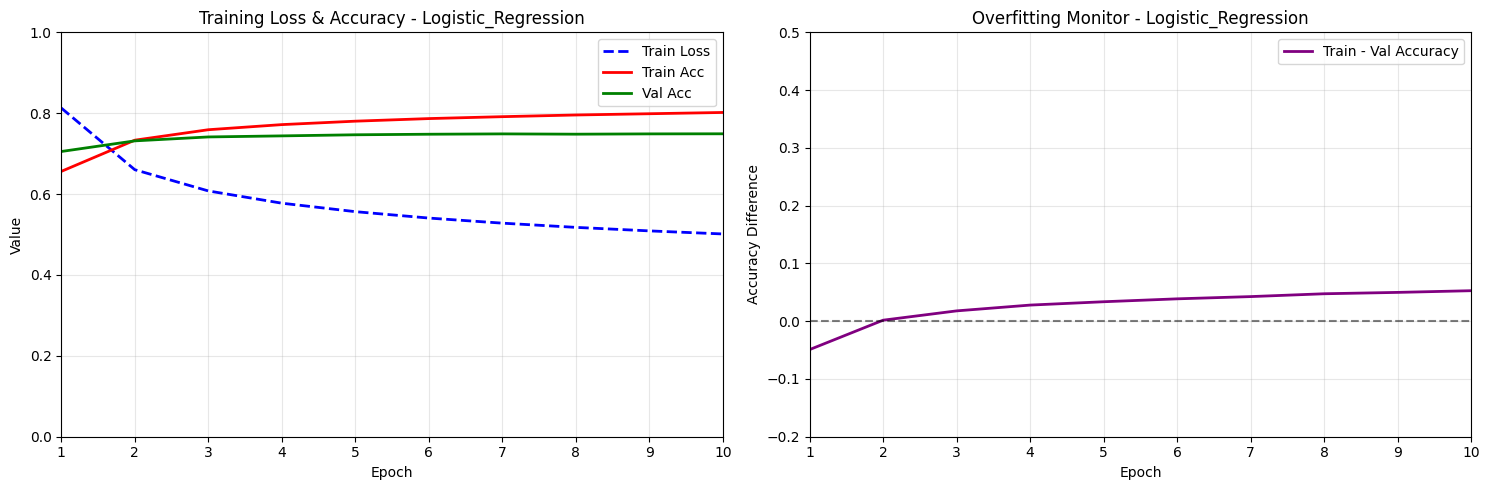


TRAINING SUMMARY
Model Name: Logistic_Regression
Final Train Loss: 0.5014
Final Train Accuracy: 0.8018
Final Val Loss: 0.6000
Final Val Accuracy: 0.7491
Best Val Accuracy: 0.7491 (Epoch 10)
Final Overfitting Gap: 0.0528


In [44]:
# 绘制训练曲线
plot_training_curves("Logistic_Regression", logreg_history)

# 打印训练摘要
print_training_summary("Logistic_Regression", logreg_history)

Testing: 100%|██████████| 53788/53788 [00:54<00:00, 983.85it/s] 



TEST RESULTS
Model Name: Logistic_Regression
Test Accuracy: 0.3987
Test Precision (weighted): 0.3682
Test Recall (weighted): 0.3987
Test F1 Score (weighted): 0.3274

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.3386    0.0392    0.0703     18650
     Neutral     0.1737    0.2023    0.1869      9971
    Positive     0.4672    0.7429    0.5736     25167

    accuracy                         0.3987     53788
   macro avg     0.3265    0.3281    0.2769     53788
weighted avg     0.3682    0.3987    0.3274     53788



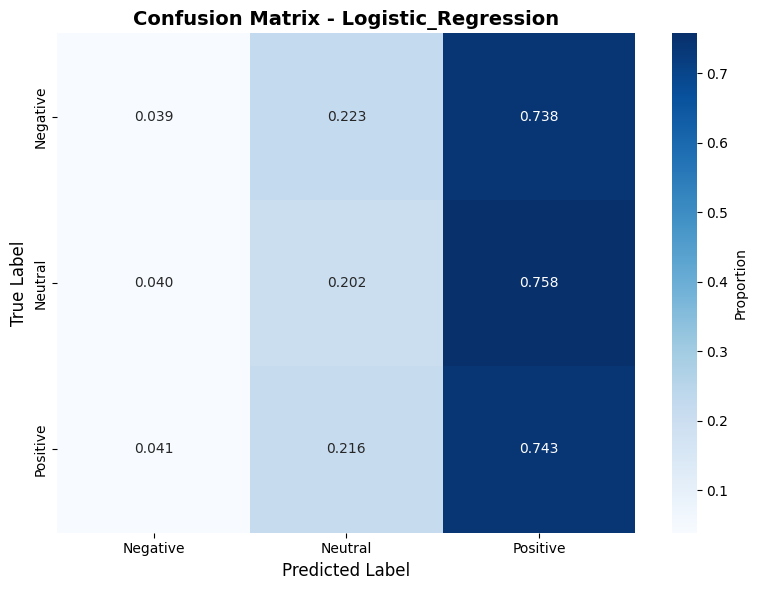


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.3386, Recall=0.0392, F1=0.0703, Support=18650
 Neutral: Precision=0.1737, Recall=0.2023, F1=0.1869, Support=9971
Positive: Precision=0.4672, Recall=0.7429, F1=0.5736, Support=25167


In [7]:
logreg_test_results = test_model_comprehensive(
    model=logreg,
    model_name="Logistic_Regression",
    test_loader=test_data_loader_tfidf,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [8]:
save_training_results(
    model=logreg,
    model_name="TF-IDF + LR",
    actual_epochs=len(logreg_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=logreg_history,
    test_results=logreg_test_results,
    save_path="model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: TF-IDF + LR (LogisticRegression)
  - 实际训练轮数: 10
  - 测试准确率: 0.7500
  - 测试F1分数: 0.7424
  - 记录时间: 2025-11-14 21:52:21
  - 总记录数: 4


{'model_class': 'LogisticRegression',
 'model_name': 'TF-IDF + LR',
 'actual_epochs': 10,
 'device': 'cuda',
 'use_pretrained_embeddings': False,
 'training_history': {'train_losses': [0.8128344511640795,
   0.6602961351180308,
   0.6078235402718483,
   0.5774938468913957,
   0.5565478299506491,
   0.5407215275539087,
   0.528128059978907,
   0.5177026979420059,
   0.5090084211185597,
   0.5013987313441206],
  'train_accuracies': [0.6561384497705253,
   0.733303321009689,
   0.7591511027536971,
   0.7718080698623151,
   0.7802978391126976,
   0.7867119773074962,
   0.7914289584395716,
   0.795612092044875,
   0.7986996430392657,
   0.8018469530851606],
  'val_losses': [0.7095065582443887,
   0.651005565836485,
   0.6263480096399465,
   0.6135729523658185,
   0.606133454438833,
   0.6020158744688051,
   0.5998621636348987,
   0.5989740520875274,
   0.5990153591169054,
   0.6000264830386476],
  'val_accuracies': [0.7053246077191939,
   0.7315944076745743,
   0.7413177660444709,
   0.7439

### 多层感知机

In [8]:
from torch.utils.data import Dataset, DataLoader

# 构建数据集类和数据整理函数
class BowDataset(Dataset):  #@save
    def __init__(self, data: DataFrame) -> None:
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, i: int):
        return self.data.iloc[i]

def collate_fn_mlp(batch):  #@save
    # 从独立样本集合中构建各批次的输入输出
    # 其中 BowDataset 类定义了一个样本的数据结构，即输入标签和输出标签的元组
    # 因此，将输入 inputs 定义为一个张量的列表，其中每个张量为原始句子中词元序列对应的索引值序列
    inputs = [torch.tensor(b[0]) for b in batch]

    # 输出的目标 targets 为该批次中由全部样例输出结果构成的张量
    targets = torch.tensor([b[1] for b in batch], dtype=torch.long)

    # 获取一个批次中每个样例的序列长度
    offsets = [0] + [i.shape[0] for i in inputs]

    # 根据序列的长度，转换为每个序列起始位置的偏移量
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # 将 inputs 列表中的张量拼接成一个大的张量
    inputs = torch.cat(inputs)

    return inputs, offsets, targets

In [9]:
from torch.nn import functional as F

class MLP(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None, freeze=True):
        super(MLP, self).__init__()

        # EmbeddingBag 层
        if pretrained_embedding_matrix is not None:
            self.embeddingbag = nn.EmbeddingBag.from_pretrained(pretrained_embedding_matrix, freeze=freeze, mode="mean")
        else:
            self.embeddingbag = nn.EmbeddingBag(vocab_size, embedding_dim)


        # 线性变换：词向量层 -> 隐含层
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)

        # 使用ReLU激活函数
        self.activate = F.relu

        # 线性变换：激活层 -> 输出层
        self.linear2 = nn.Linear(hidden_dim, num_class)

        self.dropout = nn.Dropout(0.5)
    
    def forward(self, inputs, offsets):
        embedding = self.embeddingbag(inputs, offsets)
        hidden = self.activate(self.linear1(embedding))
        hidden = self.dropout(hidden)
        outputs = self.linear2(hidden)
        return outputs

In [10]:
# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10

# 加载数据
train_dataset = BowDataset(train_idx)
val_dataset = BowDataset(val_idx)
test_dataset = BowDataset(test_idx)

train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp = MLP(len(vocab), embedding_dim, hidden_dim, num_class)
mlp.to(device)

MLP(
  (embeddingbag): EmbeddingBag(34038, 200, mode='mean')
  (linear1): Linear(in_features=200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [12]:
# MLP 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# 使用通用训练函数
mlp_history = train_model_with_validation(
    model=mlp,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device,
)

Training Epoch 1: 100%|██████████| 7827/7827 [00:33<00:00, 230.68it/s]


Epoch 1/10
    Train Loss: 0.7190	Train Accuracy: 0.6919
    Valid Loss: 0.6351	Valid Accuracy: 0.7320
    Valid Precision: 0.7209	Valid Recall: 0.7320	Valid F1: 0.7154
    ✓ New best validation loss: 0.6351
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7827/7827 [00:32<00:00, 241.44it/s]


Epoch 2/10
    Train Loss: 0.5984	Train Accuracy: 0.7532
    Valid Loss: 0.6118	Valid Accuracy: 0.7455
    Valid Precision: 0.7361	Valid Recall: 0.7455	Valid F1: 0.7370
    ✓ New best validation loss: 0.6118
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7827/7827 [00:32<00:00, 242.89it/s]


Epoch 3/10
    Train Loss: 0.5544	Train Accuracy: 0.7725
    Valid Loss: 0.6120	Valid Accuracy: 0.7497
    Valid Precision: 0.7403	Valid Recall: 0.7497	Valid F1: 0.7413
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7827/7827 [00:32<00:00, 242.96it/s]


Epoch 4/10
    Train Loss: 0.5244	Train Accuracy: 0.7863
    Valid Loss: 0.6147	Valid Accuracy: 0.7485
    Valid Precision: 0.7418	Valid Recall: 0.7485	Valid F1: 0.7422
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7827/7827 [00:31<00:00, 245.21it/s]


Epoch 5/10
    Train Loss: 0.5015	Train Accuracy: 0.7961
    Valid Loss: 0.6212	Valid Accuracy: 0.7498
    Valid Precision: 0.7400	Valid Recall: 0.7498	Valid F1: 0.7395
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.6118


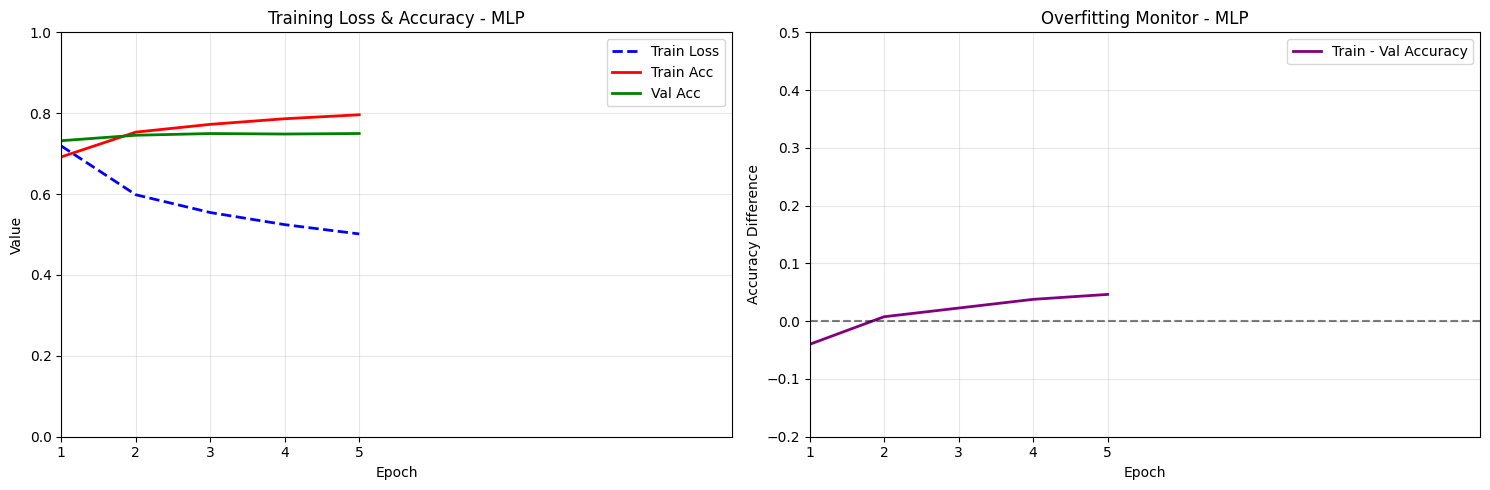


TRAINING SUMMARY
Model Name: MLP
Final Train Loss: 0.5015
Final Train Accuracy: 0.7961
Final Val Loss: 0.6212
Final Val Accuracy: 0.7498
Best Val Accuracy: 0.7498 (Epoch 5)
Final Overfitting Gap: 0.0463


In [45]:
# 绘制训练曲线
plot_training_curves("MLP", mlp_history)

# 打印训练摘要
print_training_summary("MLP", mlp_history)

Testing: 100%|██████████| 53687/53687 [00:51<00:00, 1042.11it/s]



TEST RESULTS
Model Name: MLP
Test Accuracy: 0.4318
Test Precision (weighted): 0.3995
Test Recall (weighted): 0.4318
Test F1 Score (weighted): 0.3889

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.3452    0.2388    0.2823     18614
     Neutral     0.3249    0.0922    0.1436      9924
    Positive     0.4691    0.7087    0.5645     25149

    accuracy                         0.4318     53687
   macro avg     0.3797    0.3466    0.3302     53687
weighted avg     0.3995    0.4318    0.3889     53687



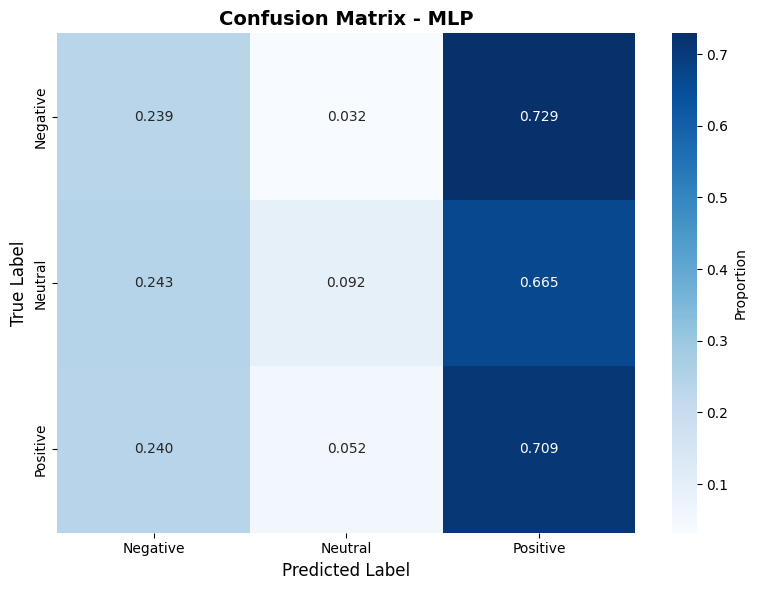


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.3452, Recall=0.2388, F1=0.2823, Support=18614
 Neutral: Precision=0.3249, Recall=0.0922, F1=0.1436, Support=9924
Positive: Precision=0.4691, Recall=0.7087, F1=0.5645, Support=25149


In [11]:
# MLP 测试过程 - 使用通用框架
mlp_test_results = test_model_comprehensive(
    model=mlp,
    model_name="MLP",
    test_loader=test_data_loader_mlp,
    device=device,
)

In [15]:
# 保存MLP训练结果
save_training_results(
    model=mlp,
    model_name="MLP",
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=mlp_history,
    test_results=mlp_test_results,
    save_path="model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: MLP (MLP)
  - 实际训练轮数: 5
  - 测试准确率: 0.7460
  - 测试F1分数: 0.7375
  - 记录时间: 2025-11-14 21:56:00
  - 总记录数: 5


{'model_class': 'MLP',
 'model_name': 'MLP',
 'actual_epochs': 5,
 'device': 'cuda',
 'use_pretrained_embeddings': False,
 'training_history': {'train_losses': [0.7189786981177754,
   0.5983766688687661,
   0.5544183261628746,
   0.5244496605935279,
   0.5014743669722689],
  'train_accuracies': [0.6919397598058005,
   0.7531980643924876,
   0.7724503321834675,
   0.7863285741663473,
   0.7961463523700013],
  'val_losses': [0.6350530879272324,
   0.6117806020364858,
   0.6119508084100677,
   0.6147288757157695,
   0.6211820756827833],
  'val_accuracies': [0.7320304057830607,
   0.7455006148228193,
   0.749729850579424,
   0.7485374669299847,
   0.7498043745575139],
  'early_stopped': True,
  'best_val_loss': 0.6117806020364858,
  'stopped_epoch': 5},
 'test_results': {'accuracy': 0.746046528954868,
  'precision': 0.7365337944236717,
  'recall': 0.746046528954868,
  'f1': 0.7374724817819455},
 'timestamp': '2025-11-14 21:56:00',
 'model_config': {'total_parameters': 6859827,
  'trainable

### 卷积神经网络

In [16]:
class CNN(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, filter_size, num_filter, num_class,
                 pretrained_embedding_matrix=None, freeze=True) -> None:
        super(CNN, self).__init__()
        if pretrained_embedding_matrix:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(embedding_dim, num_filter, filter_size, padding=1)  # padding=1 表示在卷积操作之前，将序列的前后各补充1个输入
        self.dropout = nn.Dropout(0.5)
        self.activate = F.relu
        self.linear = nn.Linear(num_filter, num_class)

    
    def forward(self, inputs):
        embedding = self.embedding(inputs)
        convolution = self.activate(self.conv1d(embedding.permute(0, 2, 1)))
        convolution = self.dropout(convolution)
        pooling = F.max_pool1d(convolution, kernel_size=convolution.shape[2])
        outputs = self.linear(pooling.squeeze(dim=2))
        return outputs

In [17]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_cnn(batch):
    inputs = [torch.tensor(b[0]) for b in batch]
    targets = torch.tensor([b[1] for b in batch], dtype=torch.long)

    # 对批次内的样本补齐，使其具有相同的长度
    inputs = pad_sequence(inputs, batch_first=True)
    return inputs, targets

In [18]:
train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class)
cnn.to(device)

CNN(
  (embedding): Embedding(34038, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [19]:
# CNN 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)

# 使用通用训练函数
cnn_history = train_model_with_validation(
    model=cnn,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7827/7827 [00:35<00:00, 222.05it/s]


Epoch 1/10
    Train Loss: 0.7284	Train Accuracy: 0.6831
    Valid Loss: 0.6612	Valid Accuracy: 0.7347
    Valid Precision: 0.7219	Valid Recall: 0.7347	Valid F1: 0.7167
    ✓ New best validation loss: 0.6612
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7827/7827 [00:33<00:00, 232.43it/s]


Epoch 2/10
    Train Loss: 0.6089	Train Accuracy: 0.7457
    Valid Loss: 0.6301	Valid Accuracy: 0.7454
    Valid Precision: 0.7405	Valid Recall: 0.7454	Valid F1: 0.7425
    ✓ New best validation loss: 0.6301
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7827/7827 [00:35<00:00, 222.13it/s]


Epoch 3/10
    Train Loss: 0.5644	Train Accuracy: 0.7689
    Valid Loss: 0.6203	Valid Accuracy: 0.7451
    Valid Precision: 0.7511	Valid Recall: 0.7451	Valid F1: 0.7474
    ✓ New best validation loss: 0.6203
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7827/7827 [00:35<00:00, 221.87it/s]


Epoch 4/10
    Train Loss: 0.5350	Train Accuracy: 0.7834
    Valid Loss: 0.5946	Valid Accuracy: 0.7557
    Valid Precision: 0.7475	Valid Recall: 0.7557	Valid F1: 0.7496
    ✓ New best validation loss: 0.5946
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7827/7827 [00:35<00:00, 223.22it/s]


Epoch 5/10
    Train Loss: 0.5080	Train Accuracy: 0.7952
    Valid Loss: 0.6115	Valid Accuracy: 0.7474
    Valid Precision: 0.7476	Valid Recall: 0.7474	Valid F1: 0.7446
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7827/7827 [00:34<00:00, 229.99it/s]


Epoch 6/10
    Train Loss: 0.4866	Train Accuracy: 0.8053
    Valid Loss: 0.6164	Valid Accuracy: 0.7437
    Valid Precision: 0.7462	Valid Recall: 0.7437	Valid F1: 0.7420
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 7827/7827 [00:34<00:00, 229.41it/s]


Epoch 7/10
    Train Loss: 0.4646	Train Accuracy: 0.8143
    Valid Loss: 0.6033	Valid Accuracy: 0.7523
    Valid Precision: 0.7454	Valid Recall: 0.7523	Valid F1: 0.7476
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5946


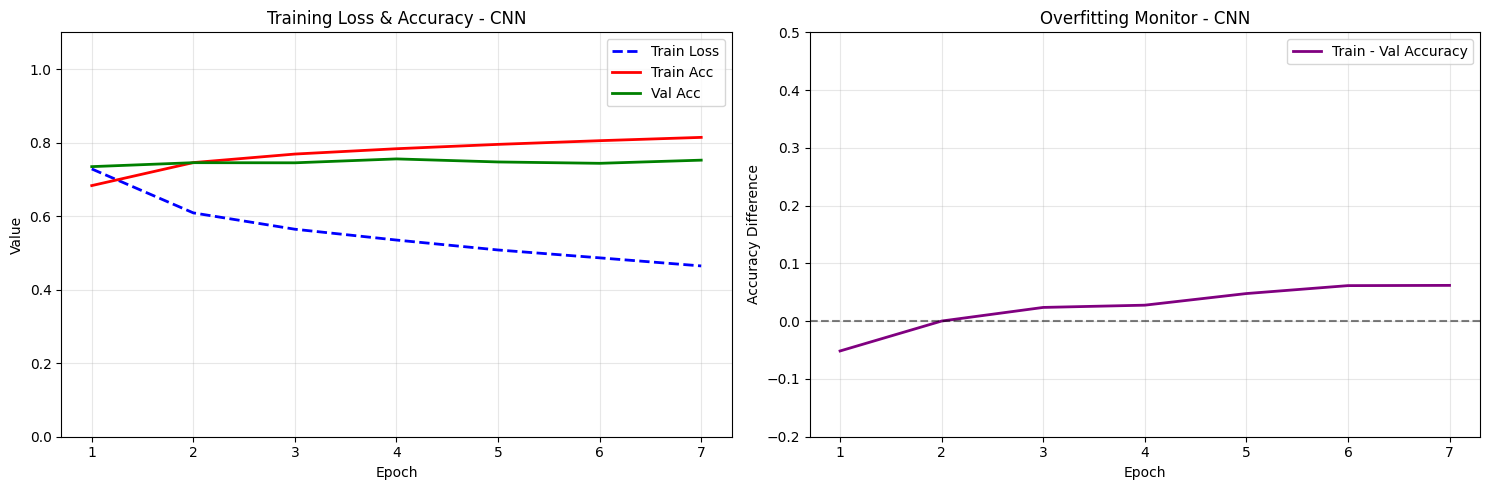


TRAINING SUMMARY
Model Name: CNN
Final Train Loss: 0.4646
Final Train Accuracy: 0.8143
Final Val Loss: 0.6033
Final Val Accuracy: 0.7523
Best Val Accuracy: 0.7557 (Epoch 4)
Final Overfitting Gap: 0.0620


In [20]:
# 绘制训练曲线
plot_training_curves("CNN", cnn_history)

# 打印训练摘要
print_training_summary("CNN", cnn_history)

Testing: 100%|██████████| 53687/53687 [00:55<00:00, 973.98it/s]



TEST RESULTS
Model Name: CNN
Test Accuracy: 0.7518
Test Precision (weighted): 0.7435
Test Recall (weighted): 0.7518
Test F1 Score (weighted): 0.7451

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7545    0.8322    0.7915     18614
     Neutral     0.5802    0.4383    0.4994      9924
    Positive     0.7997    0.8159    0.8077     25149

    accuracy                         0.7518     53687
   macro avg     0.7115    0.6955    0.6995     53687
weighted avg     0.7435    0.7518    0.7451     53687



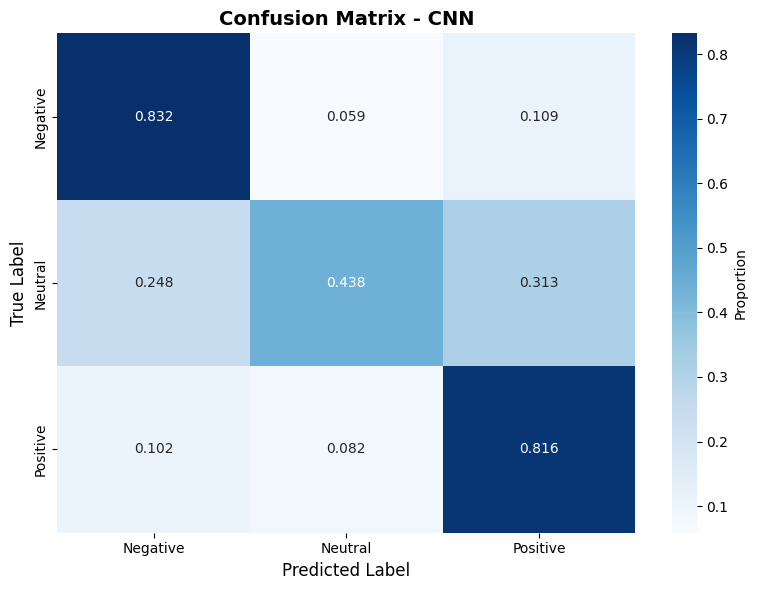


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7545, Recall=0.8322, F1=0.7915, Support=18614
 Neutral: Precision=0.5802, Recall=0.4383, F1=0.4994, Support=9924
Positive: Precision=0.7997, Recall=0.8159, F1=0.8077, Support=25149


In [21]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn,
    model_name="CNN",
    test_loader=test_data_loader_cnn,
    device=device
)

In [22]:
# 保存CNN训练结果
save_training_results(
    model=cnn,
    model_name="CNN",
    actual_epochs=len(cnn_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=cnn_history,
    test_results=cnn_test_results,
    save_path="sentiment_analysis_results.json"
)

✓ 训练结果已保存到 sentiment_analysis_results.json
  - 模型: CNN (CNN)
  - 实际训练轮数: 7
  - 测试准确率: 0.7518
  - 测试F1分数: 0.7451
  - 记录时间: 2025-11-14 22:01:20
  - 总记录数: 1


{'model_class': 'CNN',
 'model_name': 'CNN',
 'actual_epochs': 7,
 'device': 'cuda',
 'use_pretrained_embeddings': False,
 'training_history': {'train_losses': [0.7284270016203076,
   0.6088775665584585,
   0.5644191148215758,
   0.5349696848840874,
   0.5079883369880723,
   0.48657432652298815,
   0.4645678579666399],
  'train_accuracies': [0.6831081512712406,
   0.7456999808355692,
   0.7689049124824326,
   0.7834059984668456,
   0.7952280567267153,
   0.8052654273668072,
   0.8142727098505175],
  'val_losses': [0.6612384190540916,
   0.6301209024543274,
   0.6202604291834053,
   0.5946405697103336,
   0.6115124680465964,
   0.6163571513878432,
   0.603268016382821],
  'val_accuracies': [0.7346760070052539,
   0.7454447218392518,
   0.7450907329433245,
   0.7556917688266199,
   0.747400976264113,
   0.7437120393486605,
   0.7523009278235272],
  'early_stopped': True,
  'best_val_loss': 0.5946405697103336,
  'stopped_epoch': 7},
 'test_results': {'accuracy': 0.7517834857600536,
  'pre

### 长短时记忆网络

In [23]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_lstm(batch):  #@save
    lengths = torch.tensor([len(b[0]) for b in batch], dtype=torch.long)
    inputs = [torch.tensor(b[0]) for b in batch]
    targets = torch.tensor([b[1] for b in batch], dtype=torch.long)

    # 使用 pad_sequence 函数对输入序列进行填充
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, lengths, targets

In [24]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTM(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None, freeze=True):
        super(LSTM, self).__init__()
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=0.3, num_layers=2)

        self.dropout = nn.Dropout(0.5)
        
        self.output = nn.Linear(hidden_dim, num_class)

    def forward(self, inputs, lengths):
        embedding = self.embeddings(inputs)

        # 使用 pack_padded_sequence 函数对嵌入序列进行打包
        x_pack = pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False)
        hidden, (hn, cn) = self.lstm(x_pack)
        output = self.dropout(hn[-1])
        output = self.output(output)
        return output

In [25]:
train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm = LSTM(len(vocab), embedding_dim, hidden_dim, num_class)
lstm.to(device)

LSTM(
  (embeddings): Embedding(34038, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [26]:
# LSTM 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)

# 使用通用训练函数
lstm_history = train_model_with_validation(
    model=lstm,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7827/7827 [00:52<00:00, 148.23it/s]


Epoch 1/10
    Train Loss: 0.6740	Train Accuracy: 0.7099
    Valid Loss: 0.5903	Valid Accuracy: 0.7494
    Valid Precision: 0.7373	Valid Recall: 0.7494	Valid F1: 0.7383
    ✓ New best validation loss: 0.5903
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7827/7827 [00:52<00:00, 147.96it/s]


Epoch 2/10
    Train Loss: 0.5288	Train Accuracy: 0.7797
    Valid Loss: 0.5653	Valid Accuracy: 0.7595
    Valid Precision: 0.7534	Valid Recall: 0.7595	Valid F1: 0.7547
    ✓ New best validation loss: 0.5653
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7827/7827 [00:52<00:00, 149.56it/s]


Epoch 3/10
    Train Loss: 0.4438	Train Accuracy: 0.8179
    Valid Loss: 0.5731	Valid Accuracy: 0.7661
    Valid Precision: 0.7599	Valid Recall: 0.7661	Valid F1: 0.7622
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7827/7827 [00:52<00:00, 149.62it/s]


Epoch 4/10
    Train Loss: 0.3676	Train Accuracy: 0.8512
    Valid Loss: 0.6022	Valid Accuracy: 0.7624
    Valid Precision: 0.7594	Valid Recall: 0.7624	Valid F1: 0.7607
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7827/7827 [00:52<00:00, 149.62it/s]


Epoch 5/10
    Train Loss: 0.3012	Train Accuracy: 0.8803
    Valid Loss: 0.6892	Valid Accuracy: 0.7605
    Valid Precision: 0.7578	Valid Recall: 0.7605	Valid F1: 0.7587
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5653


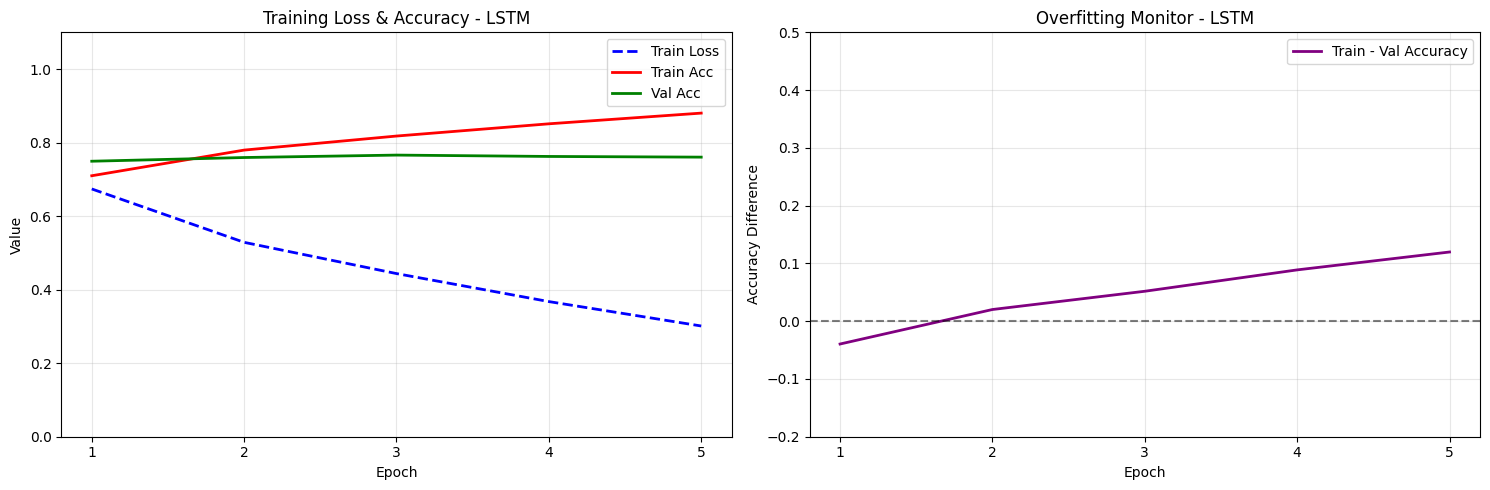


TRAINING SUMMARY
Model Name: LSTM
Final Train Loss: 0.3012
Final Train Accuracy: 0.8803
Final Val Loss: 0.6892
Final Val Accuracy: 0.7605
Best Val Accuracy: 0.7661 (Epoch 3)
Final Overfitting Gap: 0.1198


In [27]:
# 绘制训练曲线
plot_training_curves("LSTM", lstm_history)

# 打印训练摘要
print_training_summary("LSTM", lstm_history)

Testing: 100%|██████████| 53687/53687 [01:21<00:00, 658.32it/s]



TEST RESULTS
Model Name: LSTM
Test Accuracy: 0.7605
Test Precision (weighted): 0.7540
Test Recall (weighted): 0.7605
Test F1 Score (weighted): 0.7554

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8151    0.7807    0.7975     18614
     Neutral     0.5651    0.4677    0.5118      9924
    Positive     0.7834    0.8611    0.8204     25149

    accuracy                         0.7605     53687
   macro avg     0.7212    0.7032    0.7099     53687
weighted avg     0.7540    0.7605    0.7554     53687



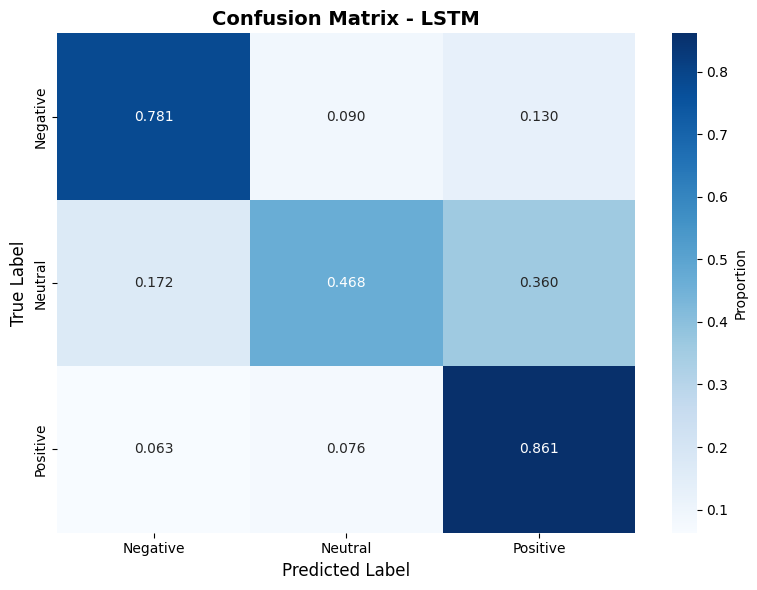


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8151, Recall=0.7807, F1=0.7975, Support=18614
 Neutral: Precision=0.5651, Recall=0.4677, F1=0.5118, Support=9924
Positive: Precision=0.7834, Recall=0.8611, F1=0.8204, Support=25149


In [28]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm,
    model_name="LSTM", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [29]:
# 保存LSTM训练结果
save_training_results(
    model=lstm,
    model_name="LSTM_Baseline",
    actual_epochs=len(lstm_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=lstm_history,
    test_results=lstm_test_results,
    save_path="sentiment_analysis_results.json"
)

✓ 训练结果已保存到 sentiment_analysis_results.json
  - 模型: LSTM_Baseline (LSTM)
  - 实际训练轮数: 5
  - 测试准确率: 0.7605
  - 测试F1分数: 0.7554
  - 记录时间: 2025-11-14 22:07:28
  - 总记录数: 2


{'model_class': 'LSTM',
 'model_name': 'LSTM_Baseline',
 'actual_epochs': 5,
 'device': 'cuda',
 'use_pretrained_embeddings': False,
 'training_history': {'train_losses': [0.6739979552342332,
   0.5287768269169295,
   0.4437904136620202,
   0.3676174724950741,
   0.3012005116284118],
  'train_accuracies': [0.7098744729781525,
   0.7796769196371535,
   0.817882010987607,
   0.85116823176185,
   0.8802702184745113],
  'val_losses': [0.5903458155878111,
   0.5652564433053651,
   0.5730578706592002,
   0.6021991039629631,
   0.6892229071701738],
  'val_accuracies': [0.7493944926780192,
   0.7594738607146849,
   0.766087863770168,
   0.7623802958601931,
   0.7605171964079442],
  'early_stopped': True,
  'best_val_loss': 0.5652564433053651,
  'stopped_epoch': 5},
 'test_results': {'accuracy': 0.7605006798666344,
  'precision': 0.754007838758865,
  'recall': 0.7605006798666344,
  'f1': 0.7554155079188022},
 'timestamp': '2025-11-14 22:07:28',
 'model_config': {'total_parameters': 7803699,
  '

### Transformer

In [30]:
import math

def length_to_mask(lengths):  #@save
    max_len = torch.max(lengths)
    mask = torch.arange(max_len, device=lengths.device).expand(lengths.shape[0], max_len) < lengths.unsqueeze(1)
    return mask

class PositionalEncoding(nn.Module):  #@save
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [ ]:
class Transformer(nn.Module):  #@save
    def __init__(
            self, 
            vocab_size, 
            embedding_dim, 
            num_class, 
            dim_feedforward=512, 
            num_head=2, 
            num_layers=2, 
            dropout=0.1, 
            max_len=128, 
            activation: str = "relu", 
            pretrained_embedding_matrix=None, 
            freeze=True
            ):
        super(Transformer, self).__init__()
        self.embedding_dim = embedding_dim
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = PositionalEncoding(embedding_dim, dropout, max_len)  # 位置编码

        encoder_layer = nn.TransformerEncoderLayer(embedding_dim, num_head, dim_feedforward, dropout, activation)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output = nn.Linear(embedding_dim, num_class)

    def forward(self, inputs, lengths):
        inputs = torch.transpose(inputs, 0, 1)

        hidden_states = self.embeddings(inputs)
        hidden_states = self.position_embedding(hidden_states)

        lengths = lengths.to(inputs.device)
        attention_mask = length_to_mask(lengths) == False

        # 根据批次中每个序列长度生成 Mask 矩阵
        hidden_states = self.transformer(hidden_states, src_key_padding_mask=attention_mask)
        hidden_states = hidden_states[0, :, :]

        # 取第一个词元的输出结果作为分类层的输入
        outputs = self.output(hidden_states)
        return outputs

In [32]:
collate_fn_trans = collate_fn_lstm  #@save

In [33]:
train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = Transformer(len(vocab), embedding_dim, num_class)
transformer.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(34038, 200)
  (position_embedding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=200, out_features=3, bias=True)
)

In [35]:
# Transformer 训练过程 - 使用通用框架
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)

# 使用通用训练函数
transformer_history = train_model_with_validation(
    model=transformer,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 7827/7827 [00:59<00:00, 131.34it/s]


Epoch 1/10
    Train Loss: 0.8786	Train Accuracy: 0.6011
    Valid Loss: 0.8436	Valid Accuracy: 0.6276
    Valid Precision: 0.6119	Valid Recall: 0.6276	Valid F1: 0.5917
    ✓ New best validation loss: 0.8436
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7827/7827 [01:01<00:00, 126.40it/s]


Epoch 2/10
    Train Loss: 0.8302	Train Accuracy: 0.6352
    Valid Loss: 0.8007	Valid Accuracy: 0.6457
    Valid Precision: 0.6379	Valid Recall: 0.6457	Valid F1: 0.6031
    ✓ New best validation loss: 0.8007
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7827/7827 [00:59<00:00, 131.15it/s]


Epoch 3/10
    Train Loss: 0.7967	Train Accuracy: 0.6555
    Valid Loss: 0.7786	Valid Accuracy: 0.6576
    Valid Precision: 0.6522	Valid Recall: 0.6576	Valid F1: 0.6489
    ✓ New best validation loss: 0.7786
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7827/7827 [00:59<00:00, 130.59it/s]


Epoch 4/10
    Train Loss: 0.7559	Train Accuracy: 0.6780
    Valid Loss: 0.7515	Valid Accuracy: 0.6838
    Valid Precision: 0.6706	Valid Recall: 0.6838	Valid F1: 0.6674
    ✓ New best validation loss: 0.7515
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7827/7827 [00:59<00:00, 132.61it/s]


Epoch 5/10
    Train Loss: 0.7339	Train Accuracy: 0.6913
    Valid Loss: 0.7343	Valid Accuracy: 0.6891
    Valid Precision: 0.6779	Valid Recall: 0.6891	Valid F1: 0.6795
    ✓ New best validation loss: 0.7343
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7827/7827 [01:00<00:00, 130.11it/s]


Epoch 6/10
    Train Loss: 0.7215	Train Accuracy: 0.7012
    Valid Loss: 0.7387	Valid Accuracy: 0.6886
    Valid Precision: 0.6828	Valid Recall: 0.6886	Valid F1: 0.6815
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 7827/7827 [00:58<00:00, 134.24it/s]


Epoch 7/10
    Train Loss: 0.7110	Train Accuracy: 0.7063
    Valid Loss: 0.7516	Valid Accuracy: 0.6907
    Valid Precision: 0.6814	Valid Recall: 0.6907	Valid F1: 0.6841
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 7827/7827 [00:58<00:00, 134.43it/s]


Epoch 8/10
    Train Loss: 0.7057	Train Accuracy: 0.7084
    Valid Loss: 0.7443	Valid Accuracy: 0.6878
    Valid Precision: 0.6818	Valid Recall: 0.6878	Valid F1: 0.6781
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.7343


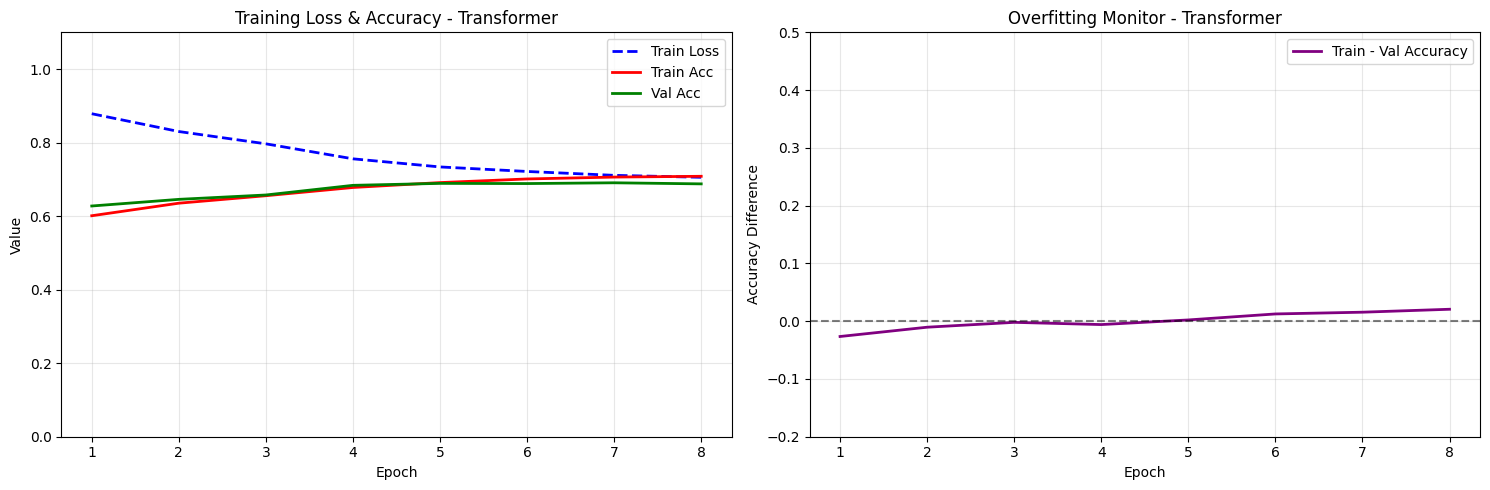


TRAINING SUMMARY
Model Name: Transformer
Final Train Loss: 0.7057
Final Train Accuracy: 0.7084
Final Val Loss: 0.7443
Final Val Accuracy: 0.6878
Best Val Accuracy: 0.6907 (Epoch 7)
Final Overfitting Gap: 0.0206


In [36]:
# 绘制训练曲线
plot_training_curves("Transformer", transformer_history)

# 打印训练摘要
print_training_summary("Transformer", transformer_history)

Testing: 100%|██████████| 53687/53687 [01:51<00:00, 481.58it/s]



TEST RESULTS
Model Name: Transformer
Test Accuracy: 0.6917
Test Precision (weighted): 0.6797
Test Recall (weighted): 0.6917
Test F1 Score (weighted): 0.6816

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.6914    0.7637    0.7258     18614
     Neutral     0.5175    0.3432    0.4127      9924
    Positive     0.7351    0.7759    0.7550     25149

    accuracy                         0.6917     53687
   macro avg     0.6480    0.6276    0.6311     53687
weighted avg     0.6797    0.6917    0.6816     53687



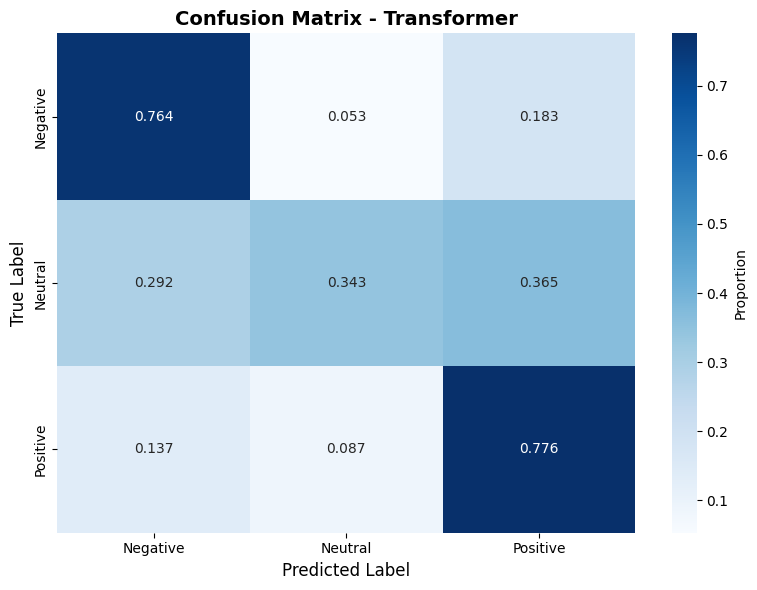


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.6914, Recall=0.7637, F1=0.7258, Support=18614
 Neutral: Precision=0.5175, Recall=0.3432, F1=0.4127, Support=9924
Positive: Precision=0.7351, Recall=0.7759, F1=0.7550, Support=25149


In [37]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer,
    model_name="Transformer",
    test_loader=test_data_loader_trans,
    device=device
)

In [38]:
# 保存Transformer训练结果
save_training_results(
    model=transformer,
    model_name="Transformer",
    actual_epochs=len(transformer_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=transformer_history,
    test_results=transformer_test_results,
    save_path="sentiment_analysis_results.json"
)

✓ 训练结果已保存到 sentiment_analysis_results.json
  - 模型: Transformer (Transformer)
  - 实际训练轮数: 8
  - 测试准确率: 0.6917
  - 测试F1分数: 0.6816
  - 记录时间: 2025-11-14 22:18:03
  - 总记录数: 3


{'model_class': 'Transformer',
 'model_name': 'Transformer',
 'actual_epochs': 8,
 'device': 'cuda',
 'use_pretrained_embeddings': False,
 'training_history': {'train_losses': [0.8786189813784169,
   0.830177747191971,
   0.7967101185200268,
   0.7559267941929454,
   0.7338690963744264,
   0.72153507998746,
   0.7109897304642805,
   0.7056730159157246],
  'train_accuracies': [0.6010963651462885,
   0.6352449853072697,
   0.6555433116136451,
   0.6779577104893318,
   0.6912729973169797,
   0.7011626421361952,
   0.7062771496103233,
   0.7084251628976619],
  'val_losses': [0.8435857134368338,
   0.8006731625535349,
   0.7785775955051575,
   0.7514520676648944,
   0.7343452275864985,
   0.7387488123664413,
   0.751582709466317,
   0.7442936705107911],
  'val_accuracies': [0.6276036814845176,
   0.6456757461713306,
   0.6575623206766777,
   0.6838133919588628,
   0.6891232253977717,
   0.688638819540187,
   0.6907254909267057,
   0.6877817937921527],
  'early_stopped': True,
  'best_val_lo


MODEL PERFORMANCE COMPARISON
      Model  Accuracy  Precision  Recall  F1 Score
        MLP    0.7460     0.7365  0.7460    0.7375
        CNN    0.7518     0.7435  0.7518    0.7451
       LSTM    0.7605     0.7540  0.7605    0.7554
Transformer    0.6917     0.6797  0.6917    0.6816


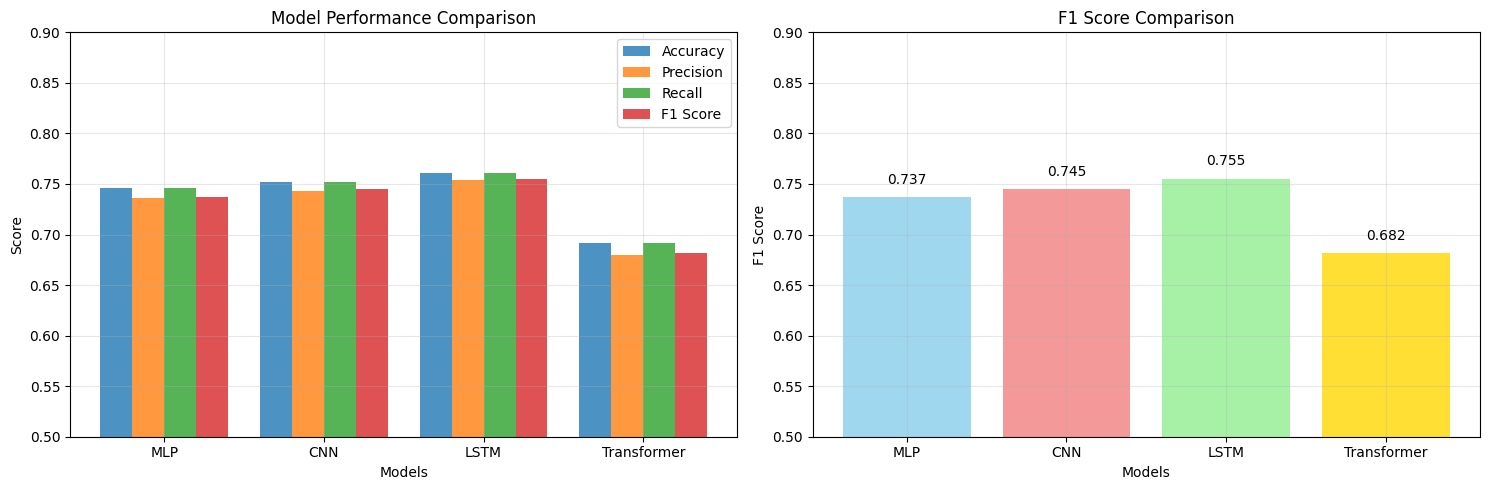


Best performing model: LSTM (F1 Score: 0.7554)


In [39]:
# 模型性能比较
def compare_models(model_results, model_names=None):
    """
    比较多个模型的性能
    
    Args:
        model_results: 模型结果字典的列表
        model_names: 模型名称列表
    """
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(model_results))]
    
    # 创建比较表格
    import pandas as pd
    
    comparison_data = []
    for i, (name, result) in enumerate(zip(model_names, model_results)):
        comparison_data.append({
            'Model': name,
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1 Score': result['f1']
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(df.round(4).to_string(index=False))
    
    # 绘制比较图表
    plt.figure(figsize=(15, 5))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_keys = ['accuracy', 'precision', 'recall', 'f1']  # 对应的字典键
    x = np.arange(len(model_names))
    width = 0.2
    
    plt.subplot(1, 2, 1)
    for i, (metric, key) in enumerate(zip(metrics, metric_keys)):
        values = [result[key] for result in model_results]
        plt.bar(x + i*width, values, width, label=metric, alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width*1.5, model_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # F1分数单独比较
    plt.subplot(1, 2, 2)
    f1_scores = [result['f1'] for result in model_results]
    bars = plt.bar(model_names, f1_scores, alpha=0.8, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'][:len(model_names)])
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # 在柱状图上显示数值
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 找出最佳模型
    best_idx = np.argmax([result['f1'] for result in model_results])
    print(f"\nBest performing model: {model_names[best_idx]} (F1 Score: {model_results[best_idx]['f1']:.4f})")

# 使用示例（在所有模型都训练完成后运行）
model_results = [
    logreg_test_results,  # Logistic Regression
    mlp_test_results,  # MLP
    cnn_test_results,  # CNN  
    lstm_test_results,  # LSTM
    transformer_test_results  # Transformer
]
model_names = ['TF-IDF + LR', 'MLP', 'CNN', 'LSTM', 'Transformer']
compare_models(model_results, model_names)